# SQL Window Functions for Northwind Traders

Corresponds to a DataQuest guided project, using the PostgreSQL version of the Northwind Traders database.

## Prerequisites

* *PostgreSQL* is installed, a DB server is running (locally)
* The Northwind Traders database has been downloaded and setup as *PostgreSQL* database
* The *psycopg2* adapter is installed as Python package
* The *SQLAlchemy* SQL Toolkit in installed as Python package

## Instructions

* Install PostgreSQL: `brew install postgresql@14`
* Start database server: `brew services start postgresql@16`
* Create `postgres` super-user: `createuser -s postgres`
* Download Northwind Traders database from `https://github.com/pthom/northwind_psql/blob/master/northwind.sql`
* Create `northwind` database:
  ```
  > psql -U postgres
  postgres=# CREATE DATABASE northwind;
  postgres=# \q
  ```
* Import the Northwind SQL file: `psql -U postgres -d northwind -f northwind.sql`
* Verify:
  ```
  > psql -U postgres -d northwind
  postgres=# \dt
  postgres=# SELECT * FROM customers;
  postgres=# \q
  ```
* Install *psycopg2* into Python virtual environment: `pip install psycopg2-binary`
* Install *SQLAlchemy* into Python virtual environment: `pip install SQLAlchemy`

In [1]:
%matplotlib inline

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from pathlib import Path

In [2]:
# Let us test the `psycopg2` adapter

# Connect to your postgres DB
conn = psycopg2.connect("dbname=northwind user=postgres")

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
cur.execute("SELECT * FROM customers")

# Retrieve query results
records = cur.fetchall()

In [3]:
len(records)

91

In [4]:
records

[('ALFKI',
  'Alfreds Futterkiste',
  'Maria Anders',
  'Sales Representative',
  'Obere Str. 57',
  'Berlin',
  None,
  '12209',
  'Germany',
  '030-0074321',
  '030-0076545'),
 ('ANATR',
  'Ana Trujillo Emparedados y helados',
  'Ana Trujillo',
  'Owner',
  'Avda. de la Constitución 2222',
  'México D.F.',
  None,
  '05021',
  'Mexico',
  '(5) 555-4729',
  '(5) 555-3745'),
 ('ANTON',
  'Antonio Moreno Taquería',
  'Antonio Moreno',
  'Owner',
  'Mataderos  2312',
  'México D.F.',
  None,
  '05023',
  'Mexico',
  '(5) 555-3932',
  None),
 ('AROUT',
  'Around the Horn',
  'Thomas Hardy',
  'Sales Representative',
  '120 Hanover Sq.',
  'London',
  None,
  'WA1 1DP',
  'UK',
  '(171) 555-7788',
  '(171) 555-6750'),
 ('BERGS',
  'Berglunds snabbköp',
  'Christina Berglund',
  'Order Administrator',
  'Berguvsvägen  8',
  'Luleå',
  None,
  'S-958 22',
  'Sweden',
  '0921-12 34 65',
  '0921-12 34 67'),
 ('BLAUS',
  'Blauer See Delikatessen',
  'Hanna Moos',
  'Sales Representative',
  'Fo

It is cumbersome to use *psycopg2* directly.

In order to obtain results as *pandas* dataframes, it is better to use *SQLAlchemy*, which is directly supported by *pandas*. Here, *psycopg2* is still used as driver. As another advantage, code written with *SQLAlchemy* can easily be switched to using a different dialect and driver.

In [5]:
from sqlalchemy import create_engine, URL
from sqlalchemy.sql import text

url_object = URL.create(
    drivername="postgresql+psycopg2",  # dialect+driver
    username="postgres",
    host="localhost",
    database="northwind",
)

engine = create_engine(url=url_object)

with engine.connect() as db_conn:
    sql_query = "SELECT * FROM customers"
    df = pd.read_sql_query(sql=text(sql_query), con=db_conn)

In [6]:
df.head()

,customer_id,company_name,contact_name,contact_title,address,city,region,postal_code,country,phone,fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,None,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,None,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,None,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,None,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,None,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


Few notes:

* The engine is created only once. It is used to open connections with the SQL database server
* `create_engine` is called with a URL, which can be composed using `URL.create`. Here, `drivername` has the form "dialect+driver", where *dialect* is the SQL dialect (*postgresql* in our case), and *driver* is the driver (*psycopg2* in our case)
* The `with engine.connect()` block ensures that the connection is closed once the query has been executed and the result returned

In [7]:
from sqlalchemy.sql import text

def run_sql_query(query, engine=engine):
    with engine.connect() as db_conn:
        results = pd.read_sql_query(sql=text(query), con=db_conn)
    return results

In [8]:
# Let us get a list of all tables and views in the database

query = """
SELECT table_name AS name,
       table_type AS type
  FROM information_schema.tables
 WHERE table_schema = 'public' AND table_type IN ('BASE TABLE', 'VIEW')
"""
run_sql_query(query)

,name,type
0,territories,BASE TABLE
1,order_details,BASE TABLE
2,employee_territories,BASE TABLE
3,us_states,BASE TABLE
4,customers,BASE TABLE
5,orders,BASE TABLE
6,employees,BASE TABLE
7,shippers,BASE TABLE
8,products,BASE TABLE
9,categories,BASE TABLE


In [10]:
tables_we_use = [
    "categories",
    "customers",
    "employees",
    "order_details",
    "orders",
    "products"
]

for table in tables_we_use:
    print(f"\n[{table}]:\n")
    print(run_sql_query(f"SELECT * FROM {table}").head())


[categories]:

   category_id   category_name  \
0            1       Beverages   
1            2      Condiments   
2            3     Confections   
3            4  Dairy Products   
4            5  Grains/Cereals   

                                         description picture  
0        Soft drinks, coffees, teas, beers, and ales      []  
1  Sweet and savory sauces, relishes, spreads, an...      []  
2                Desserts, candies, and sweet breads      []  
3                                            Cheeses      []  
4                Breads, crackers, pasta, and cereal      []  

[customers]:

  customer_id                        company_name        contact_name  \
0       ALFKI                 Alfreds Futterkiste        Maria Anders   
1       ANATR  Ana Trujillo Emparedados y helados        Ana Trujillo   
2       ANTON             Antonio Moreno Taquería      Antonio Moreno   
3       AROUT                     Around the Horn        Thomas Hardy   
4       BERGS        

In [12]:
for table in tables_we_use:
    print(f"\n[{table}]:\n")
    print(run_sql_query(f"SELECT * FROM {table}").info())


[categories]:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    8 non-null      int64 
 1   category_name  8 non-null      object
 2   description    8 non-null      object
 3   picture        8 non-null      object
dtypes: int64(1), object(3)
memory usage: 384.0+ bytes
None

[customers]:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    91 non-null     object
 1   company_name   91 non-null     object
 2   contact_name   91 non-null     object
 3   contact_title  91 non-null     object
 4   address        91 non-null     object
 5   city           91 non-null     object
 6   region         31 non-null     object
 7   postal_code    90 non-null     object
 8   country      

First, we rank employees by their total sales amount, and we also compute the number of orders they were responsible for.

In [19]:
query = """
WITH employees_and_total_sales AS (
   SELECT e.first_name,
          e.last_name,
          e.employee_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_sales,
          COUNT(o.order_id) AS num_orders
     FROM employees e
     LEFT JOIN orders o
       ON e.employee_id = o.employee_id
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY e.first_name, e.last_name, e.employee_id
)

SELECT *,
       RANK() OVER(ORDER BY total_sales DESC) AS sales_rank
  FROM employees_and_total_sales
"""
run_sql_query(query)

,first_name,last_name,employee_id,total_sales,num_orders,sales_rank
0,Margaret,Peacock,4,250187.45,420,1
1,Janet,Leverling,3,213051.30,321,2
2,Nancy,Davolio,1,202143.71,345,3
3,Andrew,Fuller,2,177749.26,241,4
4,Robert,King,7,141295.99,176,5
5,Laura,Callahan,8,133301.03,260,6
6,Anne,Dodsworth,9,82964.00,107,7
7,Michael,Suyama,6,78198.10,168,8
8,Steven,Buchanan,5,75567.75,117,9


Next, we compute the running total of sales per month.

In [28]:
query = """
WITH total_sales_per_month AS (
   SELECT DATE_TRUNC('month', o.order_date) AS order_month,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_sales
     FROM orders o
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY DATE_TRUNC('month', o.order_date)
)

SELECT order_month,
       total_sales,
       SUM(total_sales) OVER(ORDER BY order_month) AS running_total_sales
  FROM total_sales_per_month
"""
run_sql_query(query)

,order_month,total_sales,running_total_sales
0,1996-07-01 00:00:00+02:00,30192.10,30192.10
1,1996-08-01 00:00:00+02:00,26609.40,56801.50
2,1996-09-01 00:00:00+02:00,27636.00,84437.50
3,1996-10-01 00:00:00+02:00,41203.60,125641.10
4,1996-11-01 00:00:00+01:00,49704.00,175345.10
5,1996-12-01 00:00:00+01:00,50953.40,226298.50
6,1997-01-01 00:00:00+01:00,66692.80,292991.30
7,1997-02-01 00:00:00+01:00,41207.20,334198.50
8,1997-03-01 00:00:00+01:00,39979.90,374178.40
9,1997-04-01 00:00:00+02:00,55699.39,429877.79


Next, we display the percentage changes in total sales between each month and the month before.

In [30]:
query = """
WITH
total_sales_per_month AS (
   SELECT DATE_TRUNC('month', o.order_date) AS order_month,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_sales
     FROM orders o
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY DATE_TRUNC('month', o.order_date)
),
total_sales_and_prev_month_per_month AS (
   SELECT *,
          LAG(total_sales) OVER(ORDER BY order_month) AS total_sales_prev_month
     FROM total_sales_per_month
)

SELECT order_month,
       total_sales,
       ROUND(100.0 * (total_sales - total_sales_prev_month) / total_sales, 2) AS percentage_change
  FROM total_sales_and_prev_month_per_month
"""
run_sql_query(query)

,order_month,total_sales,percentage_change
0,1996-07-01 00:00:00+02:00,30192.10,NaN
1,1996-08-01 00:00:00+02:00,26609.40,-13.46
2,1996-09-01 00:00:00+02:00,27636.00,3.71
3,1996-10-01 00:00:00+02:00,41203.60,32.93
4,1996-11-01 00:00:00+01:00,49704.00,17.10
5,1996-12-01 00:00:00+01:00,50953.40,2.45
6,1997-01-01 00:00:00+01:00,66692.80,23.60
7,1997-02-01 00:00:00+01:00,41207.20,-61.85
8,1997-03-01 00:00:00+01:00,39979.90,-3.07
9,1997-04-01 00:00:00+02:00,55699.39,28.22


Next, we look at order values and classify them w.r.t. above or below average. The goal is to identify customers with the most above average orders.

In [31]:
query = """
WITH
order_values AS (
   SELECT o.order_id,
          o.customer_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS order_value
     FROM orders o
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY o.order_id, o.customer_id
),
order_values_and_customers AS (
   SELECT ov.*,
          c.company_name,
          c.contact_name
     FROM order_values ov
     JOIN customers c
       ON ov.customer_id = c.customer_id
)

SELECT *,
       CASE
       WHEN order_value > 1.1 * (SELECT AVG(order_value) FROM order_values) THEN 'Above Average'
       ELSE 'Average/Below Average'
       END AS order_class
  FROM order_values_and_customers
"""
run_sql_query(query)

,order_id,customer_id,order_value,company_name,contact_name,order_class
0,11038,SUPRD,751.00,Suprêmes délices,Pascale Cartrain,Average/Below Average
1,10782,CACTU,12.50,Cactus Comidas para llevar,Patricio Simpson,Average/Below Average
2,10725,FAMIA,287.80,Familia Arquibaldo,Aria Cruz,Average/Below Average
3,10423,GOURL,1020.00,Gourmet Lanchonetes,André Fonseca,Average/Below Average
4,10518,TORTU,4150.05,Tortuga Restaurante,Miguel Angel Paolino,Above Average
...,...,...,...,...,...,...
825,10707,AROUT,1704.00,Around the Horn,Thomas Hardy,Average/Below Average
826,10826,BLONP,730.00,Blondesddsl père et fils,Frédérique Citeaux,Average/Below Average
827,10371,LAMAI,91.20,La maison d'Asie,Annette Roulet,Average/Below Average
828,10575,MORGK,2147.40,Morgenstern Gesundkost,Alexander Feuer,Above Average


In [67]:
query = """
WITH
order_values AS (
   SELECT o.order_id,
          o.customer_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS order_value
     FROM orders o
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY o.order_id, o.customer_id
),
order_values_classified AS (
   SELECT *,
          CASE
          WHEN order_value > 1.1 * (SELECT AVG(order_value) FROM order_values) THEN 'Above Average'
          ELSE 'Average/Below Average'
          END AS order_class
     FROM order_values
)

SELECT c.customer_id,
       c.company_name,
       c.contact_name,
       COUNT(*) AS above_average_orders,
       SUM(ov.order_value) AS sum_values_above_avg
  FROM order_values_classified ov
  JOIN customers c
    ON ov.customer_id = c.customer_id
 WHERE ov.order_class = 'Above Average'
 GROUP BY c.customer_id, c.company_name, c.contact_name
 ORDER BY above_average_orders DESC, sum_values_above_avg DESC
"""
run_sql_query(query)

,customer_id,company_name,contact_name,above_average_orders,sum_values_above_avg
0,SAVEA,Save-a-lot Markets,Jose Pavarotti,25,109505.99
1,ERNSH,Ernst Handel,Roland Mendel,25,108039.03
2,QUICK,QUICK-Stop,Horst Kloss,21,110024.49
3,HUNGO,Hungry Owl All-Night Grocers,Patricia McKenna,11,46294.94
4,RATTC,Rattlesnake Canyon Grocery,Paula Wilson,9,41938.30
5,FOLKO,Folk och fä HB,Maria Larsson,9,27688.45
6,FRANK,Frankenversand,Peter Franken,7,17904.41
7,BONAP,Bon app',Laurence Lebihan,7,16024.10
8,MEREP,Mère Paillarde,Jean Fresnière,6,26808.50
9,QUEEN,Queen Cozinha,Lúcia Carvalho,6,23498.90


Next, we'd like to know about total sales per product category.

In [35]:
query = """
WITH
total_values_per_category AS (
   SELECT p.category_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_value
     FROM products p
     JOIN order_details od
       ON p.product_id = od.product_id
    GROUP BY p.category_id
)

SELECT c.category_id,
       c.category_name,
       tv.total_value,
       100.0 * tv.total_value / (SELECT SUM(total_value) FROM total_values_per_category) AS percentage
  FROM total_values_per_category tv
  JOIN categories c
    ON tv.category_id = c.category_id
 ORDER BY percentage DESC
"""
run_sql_query(query)

,category_id,category_name,total_value,percentage
0,1,Beverages,286526.95,21.154353
1,4,Dairy Products,251330.50,18.555791
2,6,Meat/Poultry,178188.80,13.155722
3,3,Confections,177099.10,13.075269
4,8,Seafood,141623.09,10.456066
5,2,Condiments,113694.75,8.394110
6,7,Produce,105268.60,7.772006
7,5,Grains/Cereals,100726.80,7.436684


Finally, what are the top 3 products in each category? As a bonus, we also sort the categories in descending order w.r.t. total value.

In [36]:
# We need `value_per_cat` in order to sort the categories. This query combines grouped accumulation with
# a window function operating on the groups.

query = """
WITH
total_values_per_product_and_category AS (
   SELECT p.product_id,
          p.category_id,
          p.product_name,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_value,
          SUM(SUM(od.quantity * od.unit_price)) OVER(PARTITION BY p.category_id) AS value_per_cat
     FROM products p
     JOIN order_details od
       ON p.product_id = od.product_id
    GROUP BY p.product_id, p.category_id, p.product_name
),
total_values_per_product_and_category_ranked AS (
   SELECT *,
          ROW_NUMBER() OVER(
             PARTITION BY category_id
             ORDER BY total_value DESC
          ) AS tv_rank
     FROM total_values_per_product_and_category
)

SELECT tv.product_name,
       c.category_name,
       tv.total_value
  FROM total_values_per_product_and_category_ranked tv
  JOIN categories c
    ON tv.category_id = c.category_id
 WHERE tv_rank <= 3
 ORDER BY tv.value_per_cat DESC, tv.total_value DESC
"""
run_sql_query(query)

,product_name,category_name,total_value
0,Côte de Blaye,Beverages,149984.2
1,Ipoh Coffee,Beverages,25079.2
2,Chang,Beverages,18559.2
3,Raclette Courdavault,Dairy Products,76296.0
4,Camembert Pierrot,Dairy Products,50286.0
5,Mozzarella di Giovanni,Dairy Products,25738.8
6,Thüringer Rostbratwurst,Meat/Poultry,87736.4
7,Alice Mutton,Meat/Poultry,35482.2
8,Perth Pasties,Meat/Poultry,21510.2
9,Tarte au sucre,Confections,49827.9


Here is a fun one. For each employee, determine the total sales volume of all employees reporting to him/her, directly or indirectly, including the employee him/herself. This requires a recursive CTE.

This example is a bit more difficult than what is shown in the course. In order to keep things simple, we need to use a top-down recursion (from root towards leaves). But the summation of total sales works bottom-up. Our solution is to create a table `all_reports` with tuples `(employee_id, report)`, where each (direct or indirect) report relationship is one row, with the added convention that each employee reports to itself. The summation of total sales is then accomplished with a join and grouping aggregation.

Notes:

* We can use several CTEs, one of which is recursive. The recursive one comes first
* We create `total_values_per_employee` in two steps, using a left join and `COALESCE` (which maps `null` to 0). This is because managers may not be linked to orders themselves
* In the final query, we join `total_values_per_employee tv` with `all_reports ar` on the condition `tv.employee_id = ar.report`, **not** with `ar.employee_id`. This ensures that we sum the total_values over reports
* We also display the value of orders assigned to the employee directly, as `total_value_self`, as well as the employee name. To this end, we add `employee_name` in `total_values_per_employee` and join this table a second time, aligning to `ar.employee_id`

In [63]:
query = """
WITH RECURSIVE
all_reports(employee_id, report) AS (

SELECT employee_id AS employee_id,
       employee_id AS report
  FROM employees

UNION ALL

SELECT ar.employee_id AS employee_id,
       e.employee_id AS report
  FROM employees e
  JOIN all_reports ar
    ON e.reports_to = ar.report
),
total_values_per_employee_temp AS (
   SELECT o.employee_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_value
     FROM orders o
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY o.employee_id
),
total_values_per_employee AS (
   SELECT e.employee_id,
          e.last_name || ', ' || e.first_name AS employee_name,
          COALESCE(tv.total_value, 0) AS total_value
     FROM employees e
     LEFT JOIN total_values_per_employee_temp tv
       ON e.employee_id = tv.employee_id
)

SELECT ar.employee_id,
       tv2.employee_name,
       SUM(tv.total_value) AS total_value_reports,
       tv2.total_value AS total_value_self,
       COUNT(*) - 1 AS num_reports
  FROM all_reports ar
  JOIN total_values_per_employee tv
    ON tv.employee_id = ar.report
  JOIN total_values_per_employee tv2
    ON ar.employee_id = tv2.employee_id
 GROUP BY ar.employee_id, tv2.employee_name, total_value_self
 ORDER BY total_value_reports DESC
"""
run_sql_query(query)

,employee_id,employee_name,total_value_reports,total_value_self,num_reports
0,2,"Fuller, Andrew",1354458.59,177749.26,8
1,5,"Buchanan, Steven",378025.84,75567.75,3
2,4,"Peacock, Margaret",250187.45,250187.45,0
3,3,"Leverling, Janet",213051.30,213051.30,0
4,1,"Davolio, Nancy",202143.71,202143.71,0
5,7,"King, Robert",141295.99,141295.99,0
6,8,"Callahan, Laura",133301.03,133301.03,0
7,9,"Dodsworth, Anne",82964.00,82964.00,0
8,6,"Suyama, Michael",78198.10,78198.10,0


Identify top 20 percent of customers by purchase volume.

In [65]:
query = """
WITH
total_values_per_customer_temp AS (
   SELECT o.customer_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS total_value
     FROM orders o
     JOIN order_details od
       ON o.order_id = od.order_id
    GROUP BY o.customer_id
),
total_values_per_customer AS (
   SELECT c.customer_id,
          c.company_name,
          c.contact_name,
          COALESCE(tv.total_value, 0) AS total_value
     FROM customers c
     LEFT JOIN total_values_per_customer_temp tv
       ON c.customer_id = tv.customer_id
),
total_values_per_customer_tiled AS (
   SELECT *,
          NTILE(5) OVER(ORDER BY total_value DESC) AS tv_tile
     FROM total_values_per_customer
)

SELECT customer_id,
       company_name,
       contact_name,
       total_value
  FROM total_values_per_customer_tiled
 WHERE tv_tile = 1
"""
run_sql_query(query)

,customer_id,company_name,contact_name,total_value
0,QUICK,QUICK-Stop,Horst Kloss,117483.39
1,SAVEA,Save-a-lot Markets,Jose Pavarotti,115673.39
2,ERNSH,Ernst Handel,Roland Mendel,113236.68
3,HUNGO,Hungry Owl All-Night Grocers,Patricia McKenna,57317.39
4,RATTC,Rattlesnake Canyon Grocery,Paula Wilson,52245.90
5,HANAR,Hanari Carnes,Mario Pontes,34101.15
6,FOLKO,Folk och fä HB,Maria Larsson,32555.55
7,MEREP,Mère Paillarde,Jean Fresnière,32203.90
8,KOENE,Königlich Essen,Philip Cramer,31745.75
9,QUEEN,Queen Cozinha,Lúcia Carvalho,30226.10


Next, we plot the cumulative sales for each product category.

/var/folders/kj/trnztfjn67j9by8wztm_6y8m0000gn/T/ipykernel_65610/1043199911.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30)


[Text(9678.0, 0, '1996-07'),
 Text(9770.0, 0, '1996-10'),
 Text(9862.0, 0, '1997-01'),
 Text(9952.0, 0, '1997-04'),
 Text(10043.0, 0, '1997-07'),
 Text(10135.0, 0, '1997-10'),
 Text(10227.0, 0, '1998-01'),
 Text(10317.0, 0, '1998-04')]

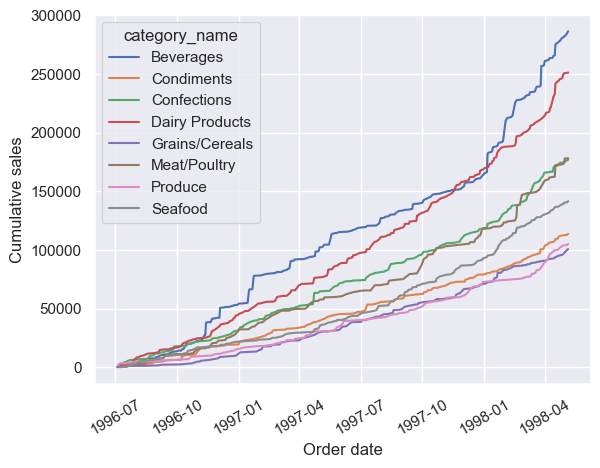

In [78]:
query = """
WITH
orders_and_products AS (
   SELECT o.order_id,
          p.product_id,
          o.order_date,
          p.category_id,
          c.category_name,
          od.quantity * od.unit_price AS value
     FROM order_details od
     JOIN orders o
       ON od.order_id = o.order_id
     JOIN products p
       ON od.product_id = p.product_id
     JOIN categories c
       ON p.category_id = c.category_id
)

SELECT category_name,
       order_date,
       SUM(value) OVER(
          PARTITION BY category_id
          ORDER BY order_date
       ) AS cumul_sales
  FROM orders_and_products
"""
result = run_sql_query(query)

sns.set_theme()
fig, ax = plt.subplots()
sns.lineplot(
    data=result,
    x="order_date",
    y="cumul_sales",
    hue="category_name",
    ax=ax,
)
ax.set_xlabel("Order date")
ax.set_ylabel("Cumulative sales")
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=30)

Finally, we identify products whose total sales exceed the 75-th percentile, and plot them as a horizontal bar plot.

Text(0.5, 0, 'Total sales')

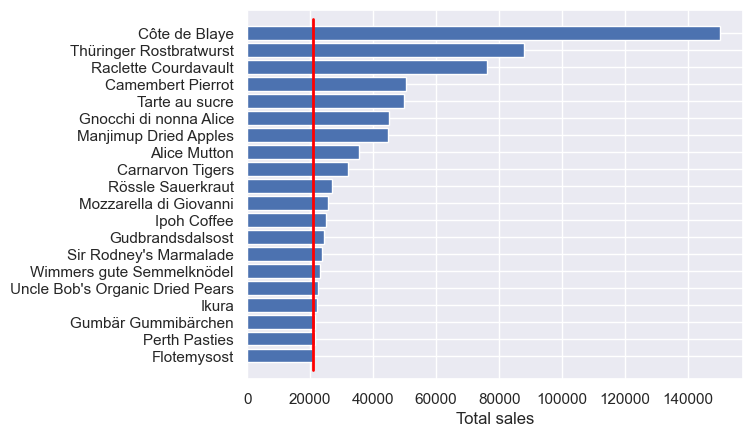

In [91]:
ctes_for_query = """
WITH
sales_per_product_temp AS (
   SELECT p.product_id,
          ROUND(CAST(SUM(od.quantity * od.unit_price) AS numeric), 2) AS sales
     FROM products p
     JOIN order_details od
       ON p.product_id = od.product_id
    GROUP BY p.product_id
),
sales_per_product AS (
   SELECT p.product_id,
          p.product_name,
          COALESCE(sp.sales, 0) AS sales
     FROM products p
     LEFT JOIN sales_per_product_temp sp
       ON p.product_id = sp.product_id
)
"""

perc_query = ctes_for_query + """

SELECT PERCENTILE_CONT(0.75) WITHIN GROUP(ORDER BY sales) AS perc_75
  FROM sales_per_product
"""
percentile_75 = run_sql_query(perc_query).loc[0, "perc_75"]

query = ctes_for_query + """

SELECT product_name,
       sales
  FROM sales_per_product
 WHERE sales >= {}
 ORDER BY sales
""".format(percentile_75)
result = run_sql_query(query)

sns.set_theme()
fig, ax = plt.subplots()
ax.barh(
    result["product_name"],
    result["sales"],
)
ax.axvline(x=percentile_75, ymin=0.025, ymax=0.975, color="red", linewidth=2)
ax.set_xlabel("Total sales")